# Deep Domain Confusion (DDC)

This is the implementation for the following paper:
```
@article{tzeng2014deep,
  title={Deep domain confusion: Maximizing for domain invariance},
  author={Tzeng, Eric and Hoffman, Judy and Zhang, Ning and Saenko, Kate and Darrell, Trevor},
  journal={arXiv preprint arXiv:1412.3474},
  year={2014}
}
```

The paper is also available [here](./res/Deep%20Domain%20Confusion%20-%20Maximizing%20for%20Domain%20Invariance.pdf).

### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchinfo import summary

from torch.utils.tensorboard import SummaryWriter

np.random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
import _base_model
import _dataloader_helper

#### For logging multiple runs

In [3]:
import pathlib

log_root = pathlib.Path(f'./ddc')
run_id = 1
while True:
    log_dir = log_root/f'run{run_id}'
    if not log_dir.exists():
        break
    run_id += 1

# use a previous run
# log_dir = log_root/'run1'
log_dir.mkdir(parents=True, exist_ok=True)
print(f'Logging to: {log_dir}')

Logging to: ddc\run1


### Prepare dataset

Here, we transform both the source and target datasets into the same size, and repeat the channel dimension for grayscale images, such that both datasets have the same input shape to the model.

In [4]:
input_shape = (3, 32, 32)
num_classes = 10

loader_helper = _dataloader_helper.MNIST2USPS(image_size=input_shape[1:])
src_train, src_val, src_test = loader_helper.get_src_loaders()
tgt_train, tgt_val, tgt_test = loader_helper.get_tgt_loaders()

#### Visualize some samples from both domains

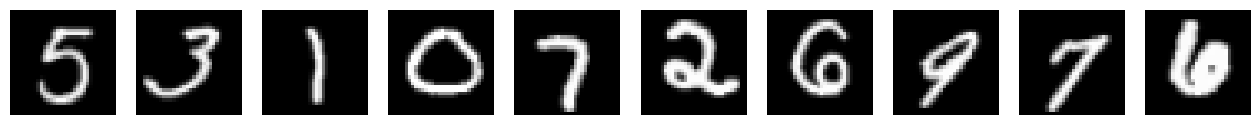

torch.Size([10, 3, 32, 32])
tensor([5, 3, 1, 0, 7, 2, 6, 9, 7, 6])


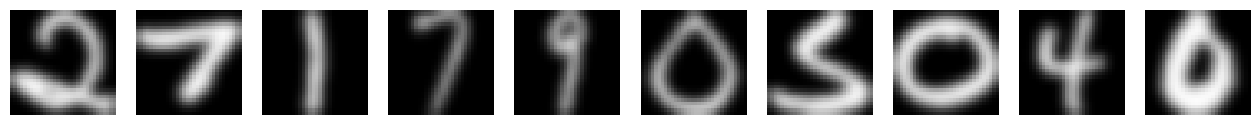

torch.Size([10, 3, 32, 32])
tensor([2, 7, 1, 7, 9, 0, 5, 0, 4, 0])


In [5]:
num_samples = 10

src_samples = next(iter(src_train))
tgt_samples = next(iter(tgt_train))

src_images, src_labels = src_samples[0][:num_samples], src_samples[1][:num_samples]
tgt_images, tgt_labels = tgt_samples[0][:num_samples], tgt_samples[1][:num_samples]

def plot_samples(samples, figsize=(16, 6)):
    fig, ax = plt.subplots(1, num_samples, figsize=figsize)
    for i in range(num_samples):
        ax[i].imshow(np.transpose(samples[i], (1, 2, 0)))
        ax[i].axis('off')
    plt.show()

plot_samples(src_images)
print(src_images.shape)
print(src_labels)

plot_samples(tgt_images)
print(tgt_images.shape)
print(tgt_labels)

## DDC

The domain adaptation schema of DDC is outlined in the figure below (note that the model architecture shown below differs from our implementation):<br>
<img src="./res/images/ddc-overview.png" width="500">

It achieves alignment bewteen the source and target domain by minimizing the maximium mean discrepancy (MMD) between the deep features from the respective domains. The MMD is a measure of the distance between two distributions, whose empirical estimate is given by:
$$\begin{align*}
\text{MMD}(X_S, X_T) &= \left\| \frac{1}{|X_S|} \sum_{x_s \in X_S} \phi(x_s) - \frac{1}{|X_T|} \sum_{x_t \in X_T} \phi(x_t) \right\|
\end{align*}$$
where $X_S$ and $X_T$ are datasets for the source and target domains respectively, and $\phi(x)$ is the deep feature representation of the input $x$.

The overall loss is then given by the combination of the classification loss and the MMD loss:
$$\begin{align*}
\mathcal{L} = \mathcal{L}_{\text{cls}}(X_S, Y_S) + \lambda \ \text{MMD}^2(X_S, X_T)
\end{align*}$$
where $\mathcal{L}_{\text{cls}}$ is the classification loss, and $\lambda$ is a hyperparameter that controls the balance between the two losses.

### Build our model

In [6]:
model = _base_model.CNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes
).to(device)

summary(model, input_size=(5, *input_shape))

Layer (type:depth-idx)                   Output Shape              Param #
CNNClassifier                            [5, 10]                   --
├─CNNEncoder: 1-1                        [5, 128, 2, 2]            --
│    └─ModuleList: 2-1                   --                        --
│    │    └─Sequential: 3-1              [5, 64, 15, 15]           1,792
│    │    └─Sequential: 3-2              [5, 128, 6, 6]            73,856
│    │    └─Sequential: 3-3              [5, 128, 2, 2]            147,584
├─FCHead: 1-2                            [5, 10]                   --
│    └─ModuleList: 2-2                   --                        --
│    │    └─Sequential: 3-4              [5, 3072]                 1,575,936
│    │    └─Sequential: 3-5              [5, 2048]                 6,293,504
│    │    └─Linear: 3-6                  [5, 10]                   20,490
Total params: 8,113,162
Trainable params: 8,113,162
Non-trainable params: 0
Total mult-adds (M): 121.73
Input size (MB): 0.06

### Train the model

In [7]:
def evaluate(model, val_loader, loss_fn):
    val_loss = 0
    val_acc = 0

    training = model.training
    model.eval()
    with torch.no_grad():
        for batch, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)
            y_pred, _ = model(x)
            loss = loss_fn(y_pred, y).item()
            n_correct = (y_pred.argmax(dim=1) == y).sum().item()
            val_loss += loss * x.shape[0]
            val_acc += n_correct
    model.train(training)
    
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)
    return (val_loss, val_acc)

def train(
    model,
    src_loader,
    tgt_loader,
    src_val_loader,
    tgt_val_loader,
    optimizer,
    loss_fn,
    num_steps=20000,
    alpha=1,
    checkpoint=100,
):
    model.train()

    train_stats = []
    val_stats = []
    best_val_loss = float('inf')

    src_loader_iter = iter(src_loader)
    tgt_loader_iter = iter(tgt_loader)

    tb_writer = SummaryWriter(log_dir=log_dir)

    for step in tqdm(range(num_steps)):
        try:
            src_x, src_y = next(src_loader_iter)
        except StopIteration:
            src_loader_iter = iter(src_loader)
            src_x, src_y = next(src_loader_iter)
        try:
            tgt_x, tgt_y = next(tgt_loader_iter)
        except StopIteration:
            tgt_loader_iter = iter(tgt_loader)
            tgt_x, tgt_y = next(tgt_loader_iter)
        
        src_x, src_y = src_x.to(device), src_y.to(device)
        tgt_x, tgt_y = tgt_x.to(device), tgt_y.to(device)

        src_y_pred, src_features = model(src_x)
        tgt_y_pred, tgt_features = model(tgt_x)

        # note that we do not use tgt_y
        loss_cls = loss_fn(src_y_pred, src_y)

        # the MMD loss
        loss_mmd = torch.linalg.norm(
            1/src_features.shape[0] * torch.sum(src_features, axis=0) -
            1/tgt_features.shape[0] * torch.sum(tgt_features, axis=0)
        )**2

        loss = loss_cls + alpha*loss_mmd

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % checkpoint == 0:
            src_val_loss, src_val_acc = evaluate(model, src_val_loader, loss_fn)
            tgt_val_loss, tgt_val_acc = evaluate(model, tgt_val_loader, loss_fn)

            train_stats += [[
                step,
                loss.item(),
                loss_cls.item(),
                loss_mmd.item(),
            ]]
            val_stats += [[
                step,
                src_val_loss,
                src_val_acc,
                tgt_val_loss,
                tgt_val_acc,
            ]]

            tb_writer.add_scalar('train/loss', loss.item(), step)
            tb_writer.add_scalar('train/loss_cls', loss_cls.item(), step)
            tb_writer.add_scalar('train/loss_mmd', loss_mmd.item(), step)

            tb_writer.add_scalar('val/src_loss_cls', src_val_loss, step)
            tb_writer.add_scalar('val/src_acc', src_val_acc, step)
            tb_writer.add_scalar('val/tgt_loss_cls', tgt_val_loss, step)
            tb_writer.add_scalar('val/tgt_acc', tgt_val_acc, step)

            # save the best model
            # this may be cheating since in reality the target dataset is unlabeled
            if tgt_val_loss < best_val_loss:
                best_val_loss = tgt_val_loss
                torch.save(model.state_dict(), log_dir/'tgt_best_model.pth')
    
    tb_writer.close()

    train_stats = np.array(train_stats)
    val_stats = np.array(val_stats)
    return (train_stats, val_stats)

In [8]:
train_stats, val_stats = train(
    model,
    src_train,
    tgt_train,
    src_val,
    tgt_val,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.9)),
    loss_fn=nn.CrossEntropyLoss(),
    num_steps=5000,
    alpha=0.25,
    checkpoint=100,
)

100%|██████████| 5000/5000 [05:42<00:00, 14.59it/s]


### Learning curves

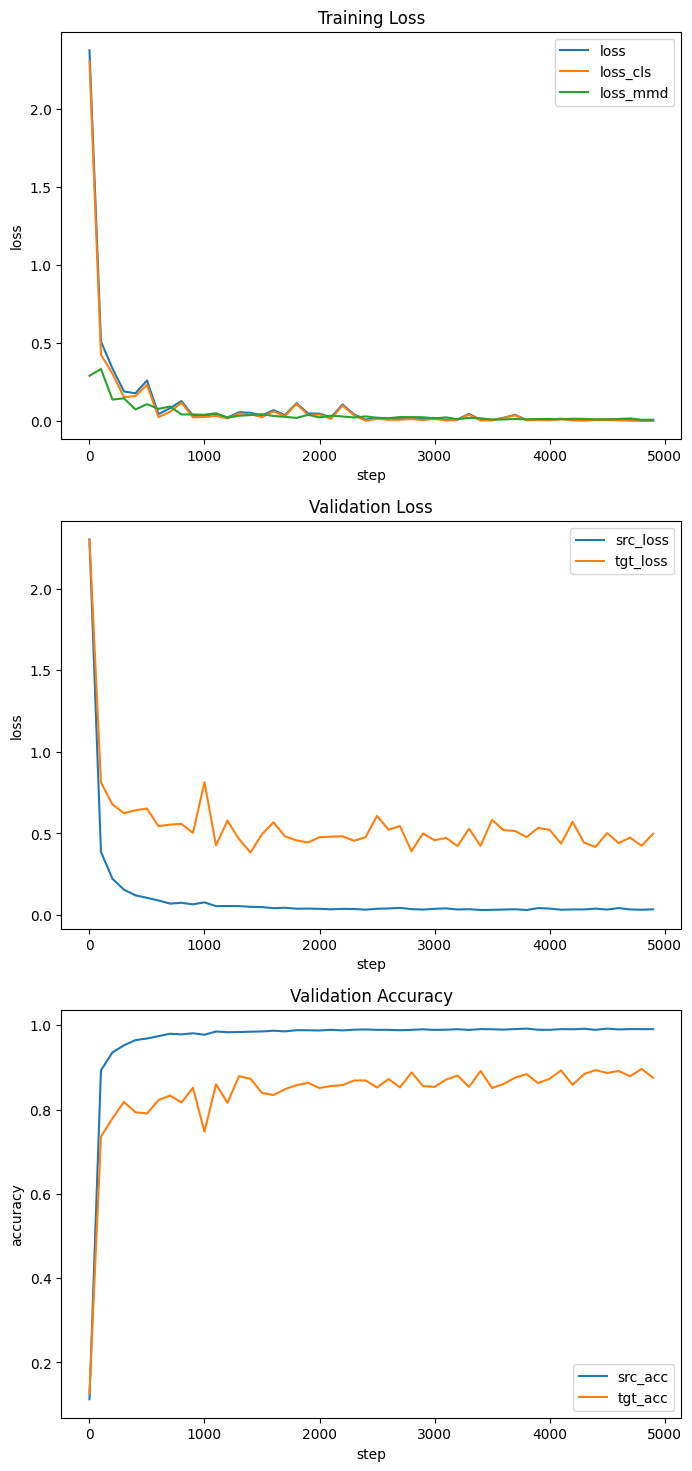

In [9]:
plt.figure(figsize=(8, 18))
plt.subplot(3, 1, 1)
plt.plot(train_stats[:, 0], train_stats[:, 1], label='loss')
plt.plot(train_stats[:, 0], train_stats[:, 2], label='loss_cls')
plt.plot(train_stats[:, 0], train_stats[:, 3], label='loss_mmd')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Training Loss')

plt.subplot(3, 1, 2)
plt.plot(val_stats[:, 0], val_stats[:, 1], label='src_loss')
plt.plot(val_stats[:, 0], val_stats[:, 3], label='tgt_loss')
plt.legend()
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Validation Loss')

plt.subplot(3, 1, 3)
plt.plot(val_stats[:, 0], val_stats[:, 2], label='src_acc')
plt.plot(val_stats[:, 0], val_stats[:, 4], label='tgt_acc')
plt.legend()
plt.xlabel('step')
plt.ylabel('accuracy')
plt.title('Validation Accuracy')
plt.show()

### Evaluate the best model

In [10]:
model.load_state_dict(torch.load(log_dir/'tgt_best_model.pth'))

src_loss, src_acc = evaluate(model, src_test, nn.CrossEntropyLoss())
tgt_loss, tgt_acc = evaluate(model, tgt_test, nn.CrossEntropyLoss())

print('Adapted model:')
print(f'src_test -> loss: {src_loss:.4f}, acc: {src_acc:.4f}')
print(f'tgt_test -> loss: {tgt_loss:.4f}, acc: {tgt_acc:.4f}')

Adapted model:
src_test -> loss: 0.0381, acc: 0.9892
tgt_test -> loss: 0.4291, acc: 0.8685
